# Lineaire regressie
Lineaire regressie is een centrale techniek binnen Machine Learning. Om de wiskunde van ML te begrijpen is het een absolute must om deze techniek ten volle te doorgronden.  
  
## Data simulatie
We beginnen met de simulatie van een simpele situatie. Stel dat er in een ideale wereld (voor koffiehuizen) een lineare relatie bestaat tussen de grootte van een bestelling en de fooi die klanten erbovenop betalen:
$$
y = b_1 + b_2x
$$
waarbij $y$ de grootte van de fooi is, $b_1$ een basis fooi en $b2$ een multiplicatieve factor voor de prijs van de aankoop.  
Het _probleem_ dat we willen oplossen is het achterhalen van $b1$ en $b2$.  
We verzamelen daarvoor data van 50 aankopen en houden er rekening mee dat er een meetfout zal zijn: de lineaire relatie zal niet altijd perfect zijn.  
Ons model voor de data is het volgende:

$$
\begin{align}
\pmb{y} &= b_1 + b_2\pmb{x} + \pmb{e} \cr
\pmb{y} &= \pmb{X}\pmb{b} + \pmb{e}
\end{align}
$$

met

$$
\pmb{X} = \begin{bmatrix}
1 & x_1 \cr
1 & x_2 \cr
\vdots & \vdots \cr
1 & x_n \cr
\end{bmatrix}
$$

$$
\pmb{b} = \begin{bmatrix}
b_1 \cr
b_2
\end{bmatrix}
$$

$$
e_i \sim N(0, \sigma)
$$

Dit laatste is ons _noise_ model: we gaan ervan uit dat ieder data punt een additieve ruis component heeft
$e_i = y_i - b_1 - b_2*x_i$ die een _normale verdeling_[^prob] volgt met gemiddelde $0$ en _standaardafwijking_ $1$.
Hier onthouden we de implicatie:

$$
\begin{align}
E(e_i) &= 0 \cr
E{\pmb{y}} &= \pmb{X}\pmb{b}
\end{align}
$$

::: {tip}
Merk terloops op dat we in dit model ervan uitgaan dat de aankoopprijzen $\pmb{x}$ zijn wat ze zijn, dus verkregen zijn _zonder_ meetfout.
:::

Om data te simuleren gebruikten we de volgende waarden voor de parameters:

$$
\begin{align}
b1 &= 0.50 \cr
b2 &= 0.15 \cr
\sigma &= 0.30
\end{align}
$$

Voor de grootte van de orders $\pmb{x}$ te simuleren, trekken we 50 samples uit een _uniforme verdeling_[^prob] met de volgende parameters.

$$
x_i \sim U(3, 25)
$$

[^prob]: We komen hierop terug in de secties over probabiliteit. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

☕ COFFEE SHOP TIPPING ANALYSIS
True relationship: Tip = $0.50 + 15.0% × Order Total
We collected data from 50 customers
Order range: $3.96 - $24.46
Tip range: $0.94 - $3.90


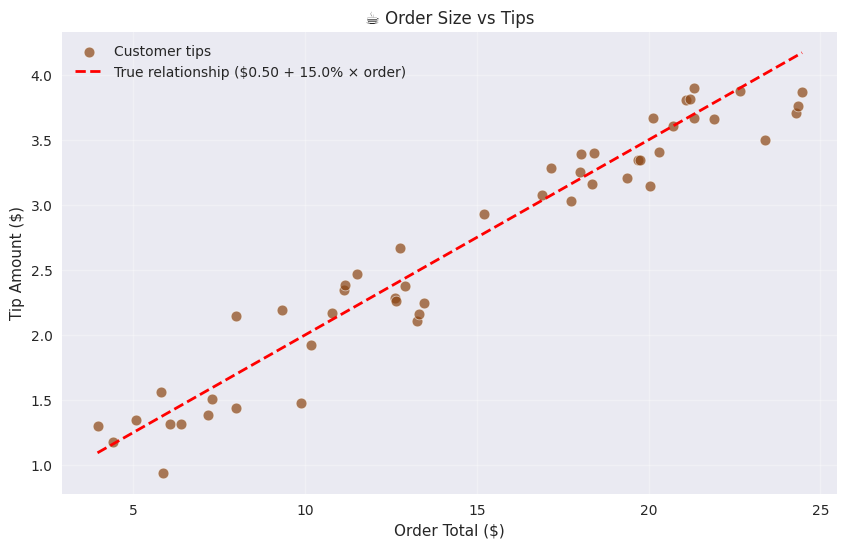


📊 Quick stats:
Average tip percentage: 19.1%
Most generous tip: $3.90 (on $21.31 order)
Most modest tip: $0.94 (on $5.86 order)


In [2]:
rng = np.random.default_rng(42)  # Create a random number generator

# Set style for prettier plots
plt.style.use("seaborn-v0_8")

# Simulate realistic coffee shop data
n_customers = 50

# True relationship: people generally tip ~15% plus a small base amount
true_tip_rate = 0.15  # 15% of order total
true_base_tip = 0.50  # $0.50 base tip regardless of order size
tip_noise_std = 0.30  # Some randomness in tipping behavior

# Generate realistic order totals ($3 to $25)
order_totals = rng.uniform(3, 25, n_customers)
order_totals = np.sort(order_totals)  # Sort for nicer visualization

# Generate corresponding tip amounts with realistic noise
true_tips = true_tip_rate * order_totals + true_base_tip
tip_noise = rng.normal(0, tip_noise_std, n_customers)
observed_tips = np.maximum(0, true_tips + tip_noise)  # Tips can't be negative

print("☕ COFFEE SHOP TIPPING ANALYSIS")
print(f"True relationship: Tip = ${true_base_tip:.2f} + {true_tip_rate:.1%} × Order Total")
print(f"We collected data from {n_customers} customers")
print(f"Order range: ${order_totals.min():.2f} - ${order_totals.max():.2f}")
print(f"Tip range: ${observed_tips.min():.2f} - ${observed_tips.max():.2f}")

# Plot the coffee shop data
plt.figure(figsize=(10, 6))
plt.scatter(
    order_totals,
    observed_tips,
    alpha=0.7,
    color="saddlebrown",
    s=60,
    edgecolor="white",
    linewidth=0.5,
    label="Customer tips",
)
plt.plot(
    order_totals,
    true_tips,
    "r--",
    linewidth=2,
    label=f"True relationship (${true_base_tip:.2f} + {true_tip_rate:.1%} × order)",
)
plt.xlabel("Order Total ($)")
plt.ylabel("Tip Amount ($)")
plt.title("☕ Order Size vs Tips")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Quick stats for context
avg_tip_percent = np.mean(observed_tips / order_totals) * 100
print("\n📊 Quick stats:")
print(f"Average tip percentage: {avg_tip_percent:.1f}%")
print(
    f"Most generous tip: ${observed_tips.max():.2f} (on ${order_totals[np.argmax(observed_tips)]:.2f} order)"
)
print(
    f"Most modest tip: ${observed_tips.min():.2f} (on ${order_totals[np.argmin(observed_tips)]:.2f} order)"
)

## _Loss_ functie

:::{note} Definitie
:class: dropdown
De _Loss_ functie is de wiskundige functie die de _sub-optimaliteit_ uitdrukt van parameterschattingen in een bepaalde context. Het doel van het optimalisatie-algorithme is om de output van die functie te _minimaliseren_.[^ml_principles]

:::

We kiezen hier voor de _Sum of Squared Errors (SSE)_ functie[^ml_principles]:

$$
J_{SSE}(f(\pmb{x}); \pmb{y}) = \sum_{i=1}^M(y_i-f(x_i))^2
$$

waarbij

$$
f(\pmb{x}) = \pmb{X}\pmb{b} = \hat{\pmb{y}}
$$

De vector $\pmb{y}$-hoedje ($\hat{\pmb{y}}$) staat voor onze _voorspelde waarden_ voor de eigenlijke fooien $\pmb{y}$ _op basis van onze schattingen_ voor de parameter $b_1$, $b_2$ (de argumenten van de _functie_ $f(\pmb{x})$) op een bepaald moment in het leerproces.

:::{note} _Squared_ $L^2$ _loss_
:class: dropdown
Merk op dat we de SSE _loss_ kunnen schrijven als:

$$
\begin{align}
J_{SSE}(f(\pmb{x}); \pmb{y}) &= \sum_{i=1}^M(y_i-\hat{y_i})^2 \cr
&= \sum_{i=1}^M(y_i-\hat{y_i})(y_i-\hat{y_i})
\end{align}
$$

als we het verschil tussen _geobserveerde_ fooi en _geschatte_ fooi $(y_i-\hat{y_i})$ aanduiden met $\pmb{d_i}$, krijgen we:

$$
\begin{align}
J_{SSE}(f(\pmb{x}); \pmb{y}) &= \sum_{i=1}^Md_id_i \cr
&= \pmb{d}^T\pmb{d}
\end{align}
$$

Terugkijkend naar de definitie van de Euclidische norm ($L^2$; $||\pmb{a}||_2 = \sqrt{\pmb{a}^T\pmb{a}}$), volgt dat de SSE _loss_ overeenkomt met het _kwadraat_ van de $L^2$ norm van de vector van verschillen $\pmb{d}$ tussen geobserveerde waarden $\pmb{y}$ en geschatte waarden $\hat{\pmb{y}}$. 
:::

**De bedoeling van het _leeralgoritme_ is dus om op zoek te gaan naar waarden voor de model parameters $\pmb{b}$ die de SSE _loss_ _minimaliseren_**.

[^ml_principles]: Zoals gezien in de cursus _ML Principles_

In [3]:
def calculate_loss(b1, b2, x, y):
    """
    Calculate how badly our guessed relationship predicts actual tips.

    Parameters
    ----------
    b1 : float
        The base tip amount in dollars
    b2 : float
        The percentage rate (e.g., 0.15 for 15%)
    x : array
        Customer order amounts
    y : array
        Actual tips customers left

    Returns
    -------
    float : sum of squared prediction errors (lower = better)
    """
    y_hat = b1 + b2 * x
    d = y - y_hat
    loss = np.sum(d**2)  # Sum of squared errors
    return loss


# Test our loss function with the true parameters
true_loss = calculate_loss(true_base_tip, true_tip_rate, order_totals, observed_tips)
print(f"💡 Loss with TRUE relationship: {true_loss:.2f}")

# Test with some wrong guesses to see higher loss
wrong_loss_1 = calculate_loss(1.0, 0.10, order_totals, observed_tips)  # 10% + $1 base
wrong_loss_2 = calculate_loss(0.0, 0.20, order_totals, observed_tips)  # 20% + no base
print(f"❌ Loss with wrong guess #1 (10% + $1.00 base): {wrong_loss_1:.2f}")
print(f"❌ Loss with wrong guess #2 (20% + $0.00 base): {wrong_loss_2:.2f}")

💡 Loss with TRUE relationship: 2.71
❌ Loss with wrong guess #1 (10% + $1.00 base): 7.66
❌ Loss with wrong guess #2 (20% + $0.00 base): 12.80


## Naïve benadering: Monte Carlo Sampling
In een echte setting hebben we enkel toegang tot training data met fooien $\pmb{y}$ enerzijds, en order groottes $\pmb{x}$ anderzijds. We willen nu een manier hebben om 
de parameters $\pmb{b}$ te vinden die leiden tot een minimale SSE _loss_. Voorlopig houden we het op een zeer naïeve, (computationeel) inefficiënt leeralgorithme:

1. We starten met een eerste berekende gok voor de parameters en berekenen de SSE _loss_ bij de start
2. Daarna itereren we (30k keer) over volgende stappen:
    - We nemen een sample uit een normale verdeling met gemiddelde $0$ om een kleine aanpassing te doen aan de parameterschattingen (in positieve of negatieve zin).
    - We zorgen dat de bijgewerkte schattingen binnen een realistisch interval blijven.
    - We berekenen de SSE _loss_ opnieuw. Als de nieuwe SSE is gedaald, behouden we de nieuwe parameterwaarden. In het andere geval verwerpen we ze.

In [4]:
# Random number generator for reproducibility
rng = np.random.default_rng(67)
# rng = np.random.default_rng(123)

# Initial guesses
b1 = rng.uniform(0, 10)  # Base tip: Between $0 and $10
b2 = rng.uniform(0.05, 0.50)  # Tip rate: Between 5% and 50%

# Initial SSE loss
current_loss = calculate_loss(b1, b2, order_totals, observed_tips)
print(f"Current SSE loss: {current_loss:.2f} (with guess: ${b1:.2f} + {b2:.1%} × order)")

# Containers to keep track of all our attempts
b1_samples = []
b2_samples = []
loss_samples = []

n_accepted = 0  # Count how many proposals we accepted
n_samples = 30000  # Total number of samples to draw
step_size = 0.0001  # How big of a step to take when proposing new

for i in range(n_samples):
    # Propose slight changes to our current best guess
    b1_new = b1 + rng.normal(0, step_size * 5)  # Base tip can vary more
    b2_new = b2 + rng.normal(0, step_size)

    # Keep parameters reasonable (tip rate: 0-50%, base tip: $0-5)
    b1_new = np.clip(b1_new, 0, 50)
    b2_new = np.clip(b2_new, 0, 1.0)

    new_loss = calculate_loss(b1_new, b2_new, order_totals, observed_tips)

    # Decide whether this new relationship is worth keeping
    accept = False
    if new_loss < current_loss:
        # This predicts tips better - definitely keep it!
        accept = True

    if accept:
        b1 = b1_new
        b2 = b2_new
        current_loss = new_loss
        n_accepted += 1

    # Record our current best guess (whether we moved or stayed)
    b1_samples.append(b1)
    b2_samples.append(b2)
    loss_samples.append(current_loss)

    # Show progress
    if i == 0 or (i + 1) % 1000 == 0:
        tip_pct = b2 * 100
        # print(f"Sample {i + 1:5d}: {tip_pct:.1f}% + ${b1:.2f} base, loss={current_loss:.1f}")
        print(
            f"Sample {i + 1:5d}: Tip = ${b1:.2f} + {b2:.1%} × Order Total, loss={current_loss:.1f}"
        )

acceptance_rate = n_accepted / n_samples
print(f"\n✅ Finished! Accepted {acceptance_rate:.1%} of proposed changes")

Current SSE loss: 472.96 (with guess: $4.14 + 10.7% × order)
Sample     1: Tip = $4.14 + 10.7% × Order Total, loss=472.8
Sample  1000: Tip = $4.07 + 6.8% × Order Total, loss=303.0
Sample  2000: Tip = $4.00 + 2.9% × Order Total, loss=181.2
Sample  3000: Tip = $3.93 + 0.0% × Order Total, loss=120.2
Sample  4000: Tip = $3.80 + 0.0% × Order Total, loss=104.2
Sample  5000: Tip = $3.65 + 0.0% × Order Total, loss=88.5
Sample  6000: Tip = $3.50 + 0.0% × Order Total, loss=75.2
Sample  7000: Tip = $3.35 + 0.0% × Order Total, loss=63.7
Sample  8000: Tip = $3.19 + 0.0% × Order Total, loss=54.4
Sample  9000: Tip = $3.02 + 0.1% × Order Total, loss=46.7
Sample 10000: Tip = $2.84 + 0.9% × Order Total, loss=40.4
Sample 11000: Tip = $2.64 + 2.0% × Order Total, loss=34.2
Sample 12000: Tip = $2.45 + 3.2% × Order Total, loss=28.5
Sample 13000: Tip = $2.26 + 4.3% × Order Total, loss=23.5
Sample 14000: Tip = $2.07 + 5.5% × Order Total, loss=19.1
Sample 15000: Tip = $1.87 + 6.6% × Order Total, loss=15.0
Sampl

## Visualisatie van het SSE oppervlak

Nu we de Monte Carlo sampling hebben uitgevoerd, kunnen we de SSE _loss_ functie visualiseren als een 3D oppervlak. Dit geeft ons inzicht in hoe de parameters $b_1$ en $b_2$ de _loss_ beïnvloeden en waarom ons algoritme "bergafwaarts" beweegt naar het minimum.

In [5]:
from ml_courses.sim.linear_regression_sse_viz import LinearRegressionSSEVisualizer

viz = LinearRegressionSSEVisualizer(
    x_data=order_totals, y_data=observed_tips, true_bias=true_base_tip, true_slope=true_tip_rate
)

fig = viz.create_3d_surface_plot(
    bias_samples=np.array(b1_samples),
    slope_samples=np.array(b2_samples),
    loss_samples=np.array(loss_samples),
    resolution=40,
)
fig.show()

::: {tip}
Probeer de Monte Carlo simulatie ook eens met een andere _seed_ voor de random generator.
``` python
rng = np.random.default_rng(123)
```
Wat merk je?
:::

Hieronder herhalen we het naïeve Monte Carlo algorithme 10 keer en visualiseren we de resulterende regressielijnen.

In [6]:
from ml_courses.sim.monte_carlo_tips import MonteCarloTipsSimulation

sim = MonteCarloTipsSimulation()

b1_sims = []
b2_sims = []

for _ in range(10):
    sim_run = sim.run_simulation()
    print(
        f"Estimated relationship: Tip = ${sim_run['final_b1']:.2f} + {sim_run['final_b2']:.1%} × Order Total"
    )
    b1_sims.append(sim_run["final_b1"])
    b2_sims.append(sim_run["final_b2"])

Estimated relationship: Tip = $5.75 + 0.0% × Order Total
Estimated relationship: Tip = $4.65 + 0.0% × Order Total
Estimated relationship: Tip = $0.56 + 14.3% × Order Total
Estimated relationship: Tip = $3.33 + 0.0% × Order Total
Estimated relationship: Tip = $5.60 + 0.0% × Order Total
Estimated relationship: Tip = $6.05 + 0.0% × Order Total
Estimated relationship: Tip = $0.56 + 14.3% × Order Total
Estimated relationship: Tip = $4.40 + 0.0% × Order Total
Estimated relationship: Tip = $0.56 + 14.3% × Order Total
Estimated relationship: Tip = $0.56 + 14.3% × Order Total


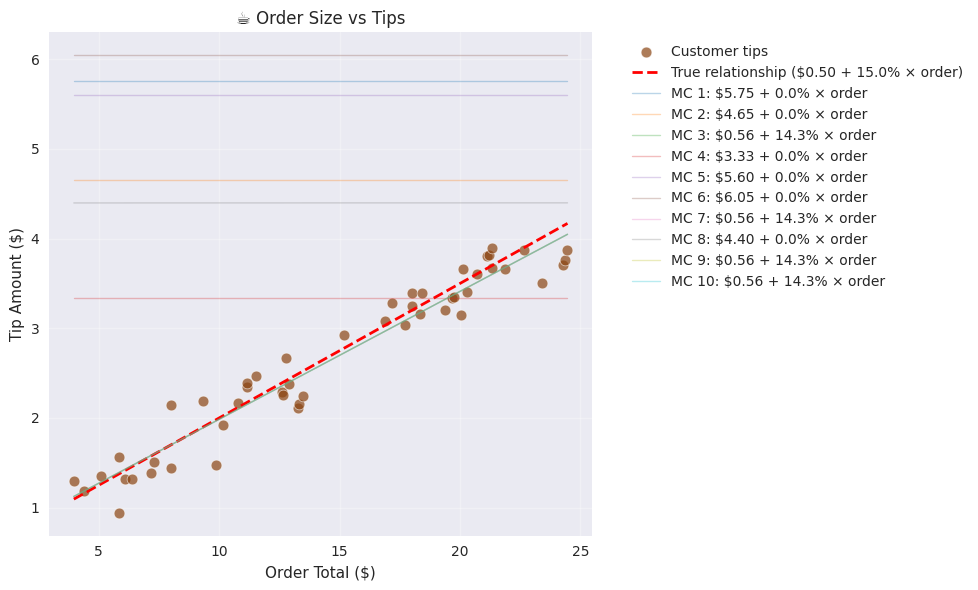

In [7]:
# Plot the simulations
plt.figure(figsize=(10, 6))
plt.scatter(
    sim.order_totals,
    sim.observed_tips,
    alpha=0.7,
    color="saddlebrown",
    s=60,
    edgecolor="white",
    linewidth=0.5,
    label="Customer tips",
)
plt.plot(
    sim.order_totals,
    sim.true_tips,
    "r--",
    linewidth=2,
    label=f"True relationship (${true_base_tip:.2f} + {true_tip_rate:.1%} × order)",
)

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

for i, (b1_sim, b2_sim) in enumerate(zip(b1_sims, b2_sims, strict=False)):
    sim_tips = b1_sim + b2_sim * sim.order_totals
    plt.plot(
        sim.order_totals,
        sim_tips,
        color=colors[i],
        linestyle="-",
        alpha=0.3,
        linewidth=1,
        label=f"MC {i + 1}: ${b1_sim:.2f} + {b2_sim:.1%} × order",
    )

plt.xlabel("Order Total ($)")
plt.ylabel("Tip Amount ($)")
plt.title("☕ Order Size vs Tips")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

De simpele Monte Carlo benadering levert duidelijk onstabiele resultaten op. In de volgende secties bekijken we betere alternatieven op basis van _calculus_. Daarvoor behandelen we eerst het concept van de **gradient** van de _loss_ functie.